# <h1 style="text-align: center;"><b>Modeling J.K. Rowling writing style</b> 


    Our corpus consists of 2 books: "Harry Potter and The Philosophers Stone" and "Harry Potter and the Chamber of Secrets".

In [1]:
import numpy as np
import re, nltk
from glob import glob
import os, re, torch
from tqdm.notebook import tqdm
from collections import defaultdict, Counter, OrderedDict
from torchtext.vocab import vocab
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dashb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
tokenized_corpus = []
hp_folder = r"\hp_books"
for file in glob(os.path.join(hp_folder, "*.txt")):
    with open(file, encoding = "utf-8") as hp:
        print(file.split("-")[1])
        book = re.sub(r"Page \| \d+ Harry Potter and .+? - J.K. Rowling", "", re.sub(r"\n", "", hp.read()))
        
        # lowercase and split on spaces to build a list of strings
        tokens = re.sub(r"([“.”,!?;:])", r" \1 ", re.sub(r"\.\.\.", ".", book.lower())).split()
        tokenized_corpus.extend(tokens) 
        
len(tokenized_corpus) # 200K tokens

 The Philosopher's Stone.txt
 The Chamber of Secrets.txt


198590

In [3]:
print(tokenized_corpus[:100]) # scan with sliding window and take slices on n tokens

['the', 'boy', 'who', 'lived', 'mr', '.', 'and', 'mrs', '.', 'dursley', ',', 'of', 'number', 'four', ',', 'privet', 'drive', ',', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', ',', 'thank', 'you', 'very', 'much', '.', 'they', 'were', 'the', 'last', 'people', 'you’d', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', ',', 'because', 'they', 'just', 'didn’t', 'hold', 'with', 'such', 'nonsense', '.', 'mr', '.', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings', ',', 'which', 'made', 'drills', '.', 'he', 'was', 'a', 'big', ',', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', ',', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache', '.', 'mrs', '.', 'dursley', 'was', 'thin']


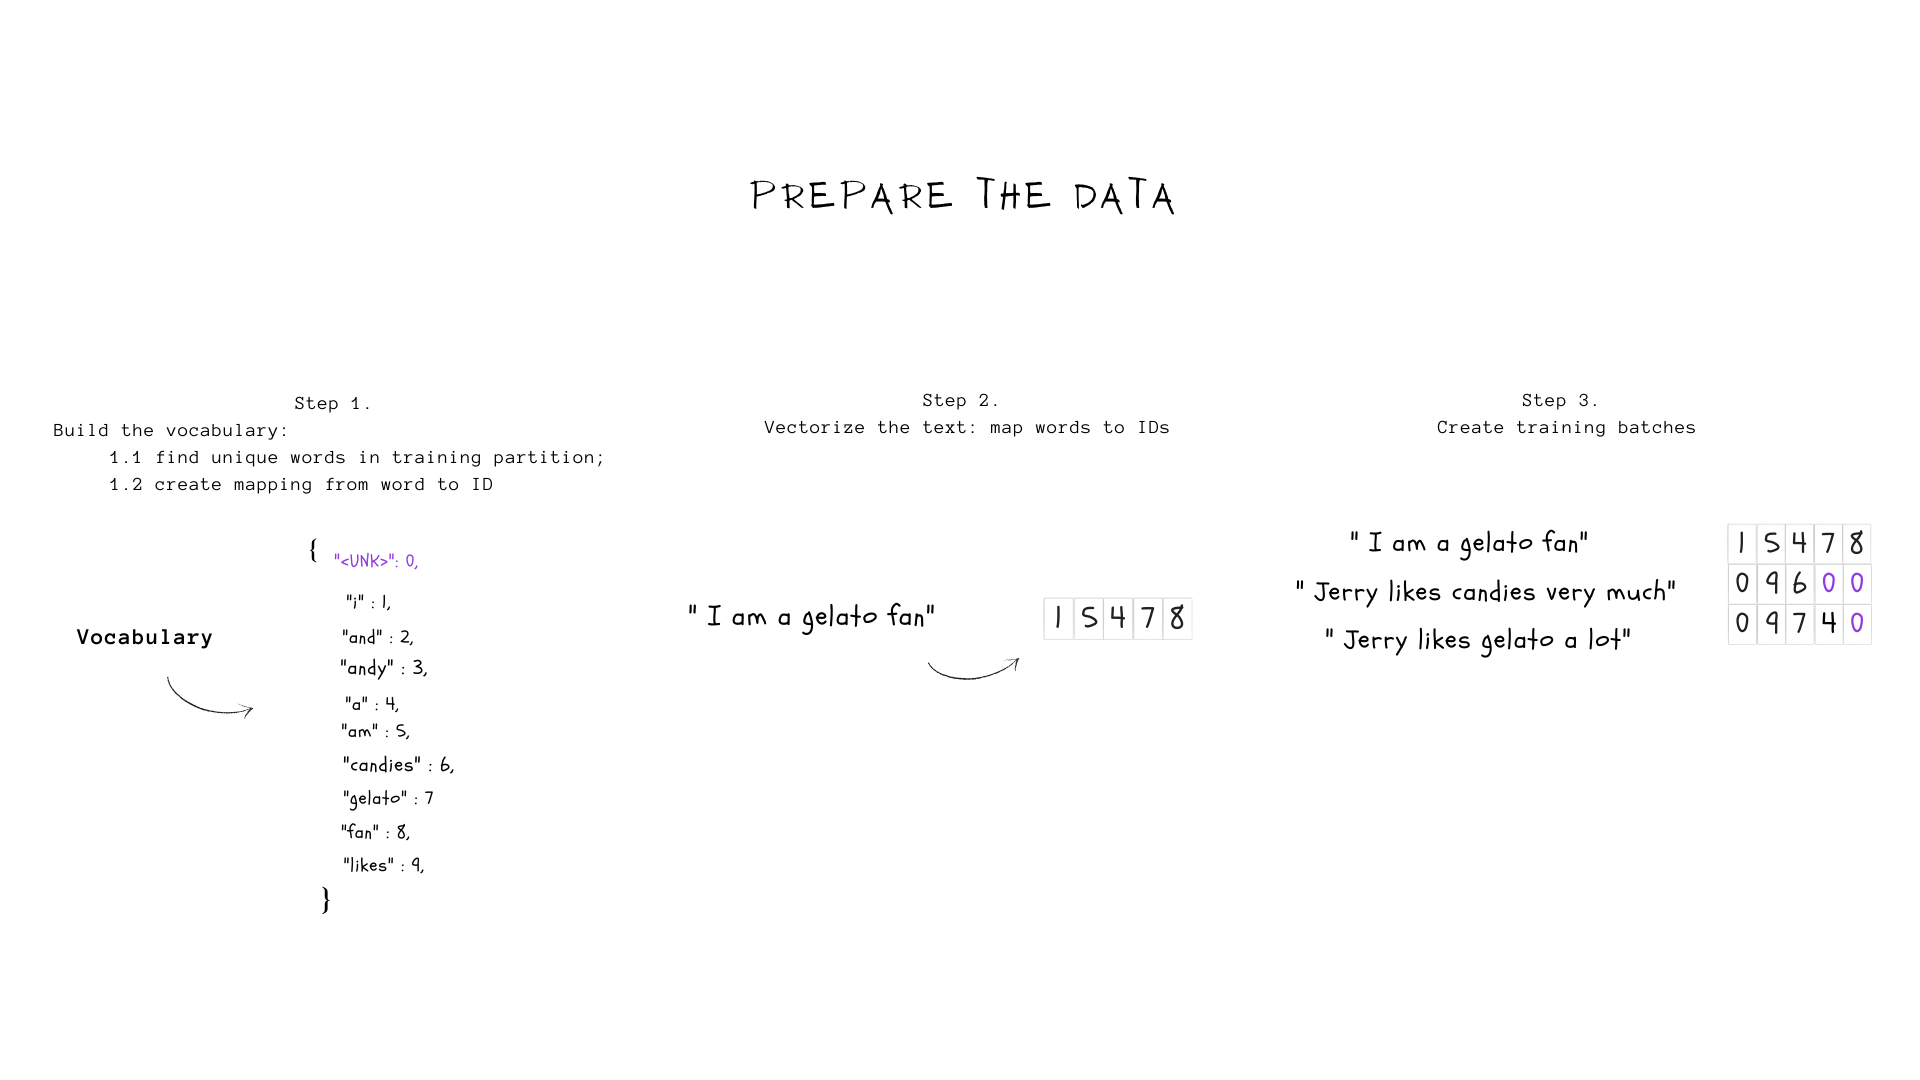

## <h6 style="text-align: center;"><b>Build token-to-integer mapping</b>

In [4]:
# 1.1 collect unique
# 1.2 build the vocabulary mapping unique words to numeric integers

In [60]:
# 1.1 collect unique
from collections import Counter, OrderedDict
token_counts=Counter(tokenized_corpus)

In [72]:
# 1.2 build the vocabulary mapping unique words to numeric integers
from torchtext.vocab import vocab
vocabulary = vocab(OrderedDict(token_counts), min_freq=2, specials=["<unk>"])
vocabulary.set_default_index(0)

In [73]:
len(vocabulary)

5504

In [56]:
vocabulary.lookup_tokens([1, 2, 3])

['boy', 'who', 'lived']

In [58]:
vocabulary.lookup_indices(["the", "boy","who"])

[0, 1, 2]

In [65]:
def encode(tokens, vocabulary):
    return vocabulary.lookup_indices(tokens)

def decode(indices, vocabulary):
    return vocabulary.lookup_tokens(indices)

## <h6 style="text-align: center;"><b>Encode and chunk the corpus</b>

    Scan the encoded corpus with a sliding window and get training sequences of 16 tokens each.

In [74]:
# transform a list of strings into a list of numbers
encoded_corpus = encode(tokenized_corpus, vocabulary)

In [77]:
print(encoded_corpus[:100])

[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17, 18, 19, 20, 21, 16, 22, 23, 10, 24, 25, 26, 27, 6, 21, 16, 1, 28, 29, 30, 31, 18, 32, 33, 34, 35, 36, 37, 38, 10, 39, 21, 40, 41, 42, 43, 44, 45, 6, 5, 6, 9, 46, 1, 47, 11, 48, 49, 50, 51, 10, 52, 53, 54, 6, 55, 46, 48, 56, 10, 0, 57, 43, 58, 59, 60, 10, 61, 55, 62, 63, 48, 26, 64, 65, 6, 8, 6, 9, 46, 66]


In [78]:
SEQ_LENGTH = 16
training_sequences = [encoded_corpus[i:i+SEQ_LENGTH] for i in range(len(encoded_corpus)-SEQ_LENGTH)]

In [80]:
len(encoded_corpus)

198590

In [81]:
training_sequences[:10]

[[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14],
 [2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15],
 [3, 4, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10],
 [4, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16],
 [5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17],
 [6, 7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17, 18],
 [7, 8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17, 18, 19],
 [8, 6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17, 18, 19, 20],
 [6, 9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17, 18, 19, 20, 21],
 [9, 10, 11, 12, 13, 10, 14, 15, 10, 16, 17, 18, 19, 20, 21, 16]]

## <h6 style="text-align: center;"><b>Create a dataset object</b>

In [87]:
from torch.utils.data import Dataset, DataLoader

class HarryPotterDataset(Dataset):
    
    def __init__(self,training_sequences ):
        self.training_sequences = training_sequences
        
    def __len__(self):
        return len(self.training_sequences)
    
    def __getitem__(self, index):
        training_window = self.training_sequences[index]
        input_sequence = torch.tensor(training_window[:-1])
        target_sequence = torch.tensor(training_window[1:])
        return input_sequence, target_sequence

hp_dataset = HarryPotterDataset(training_sequences)

In [88]:
hp_dataset[0]

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  6,  9, 10, 11, 12, 13, 10]),
 tensor([ 2,  3,  4,  5,  6,  7,  8,  6,  9, 10, 11, 12, 13, 10, 14]))

## <h6 style="text-align: center;"><b>Batchify</b>

    Create training batches of 32 sequences.

In [89]:
batch_size = 32
dataloader = DataLoader(hp_dataset, batch_size=batch_size, shuffle=True)

In [93]:
batch = next(iter(dataloader))
input_batch, target_batch = batch[0], batch[1]
input_batch.shape

torch.Size([32, 15])

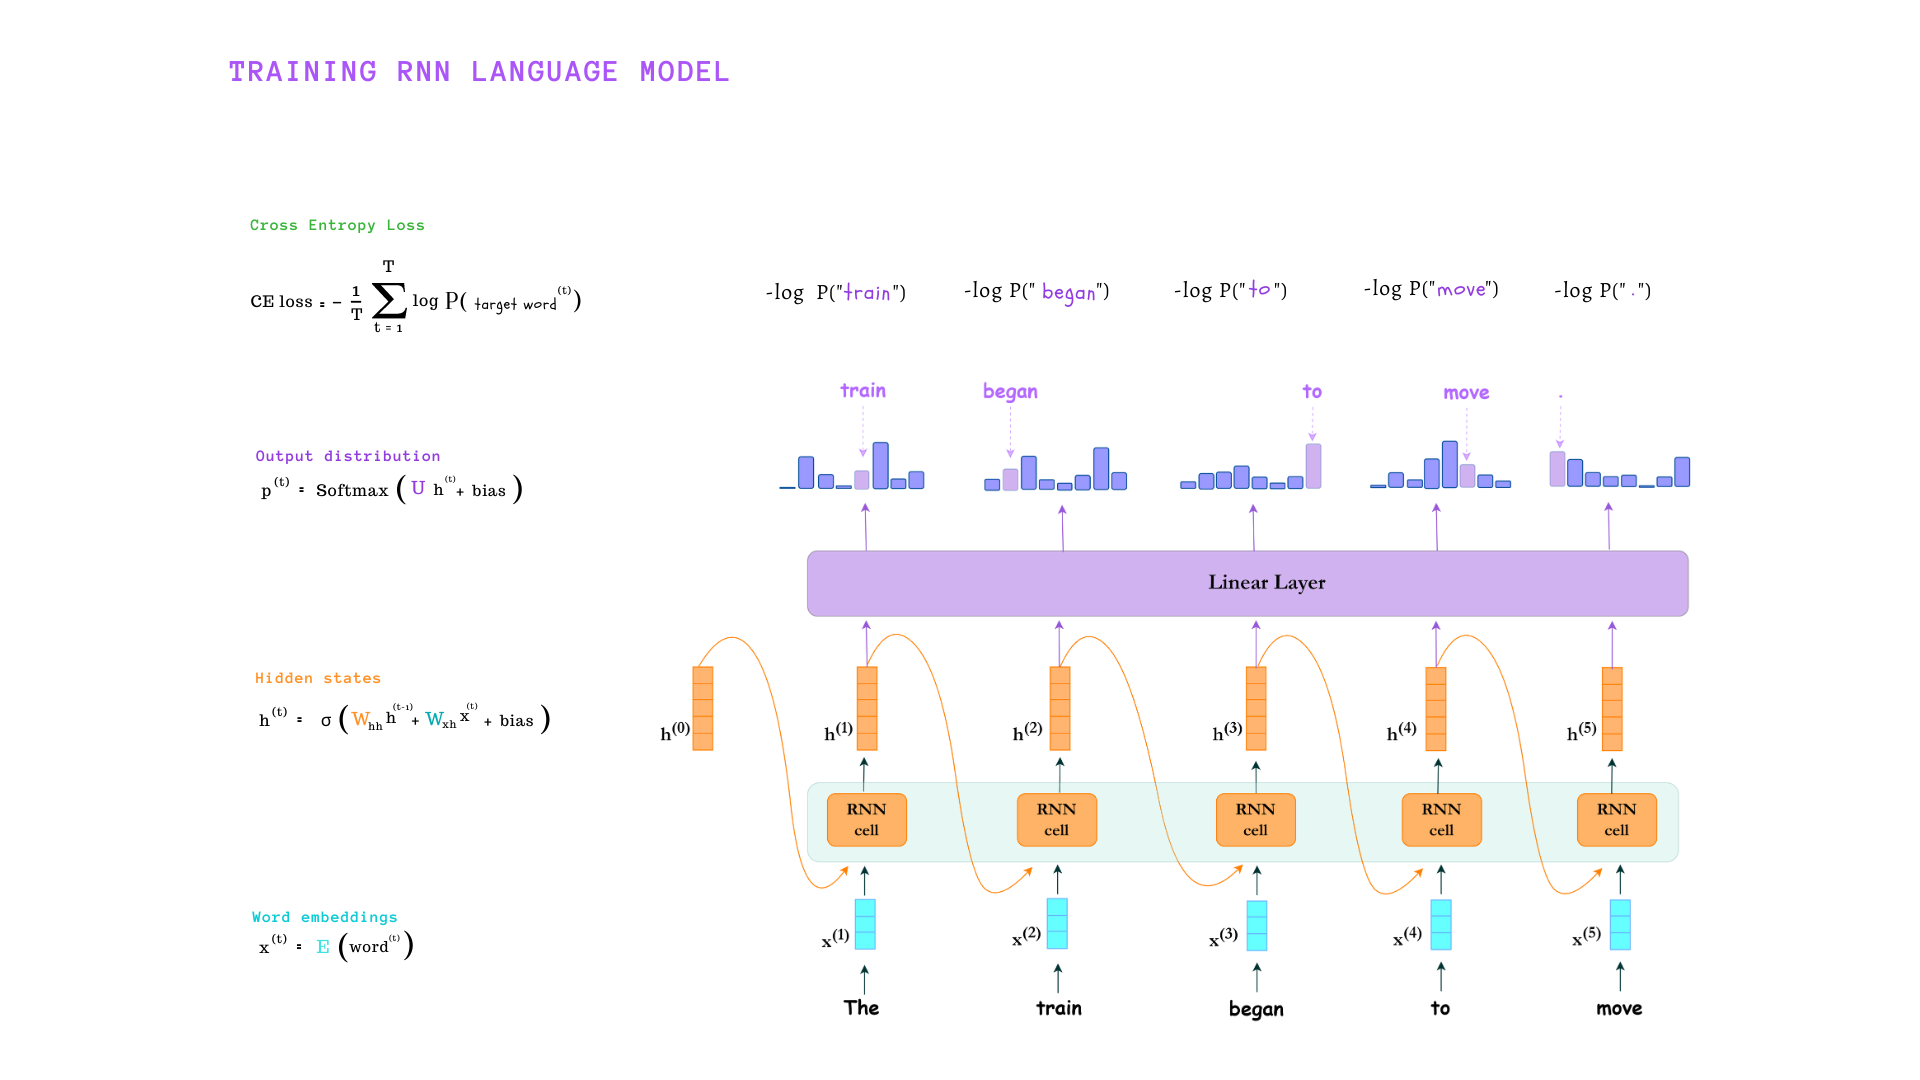

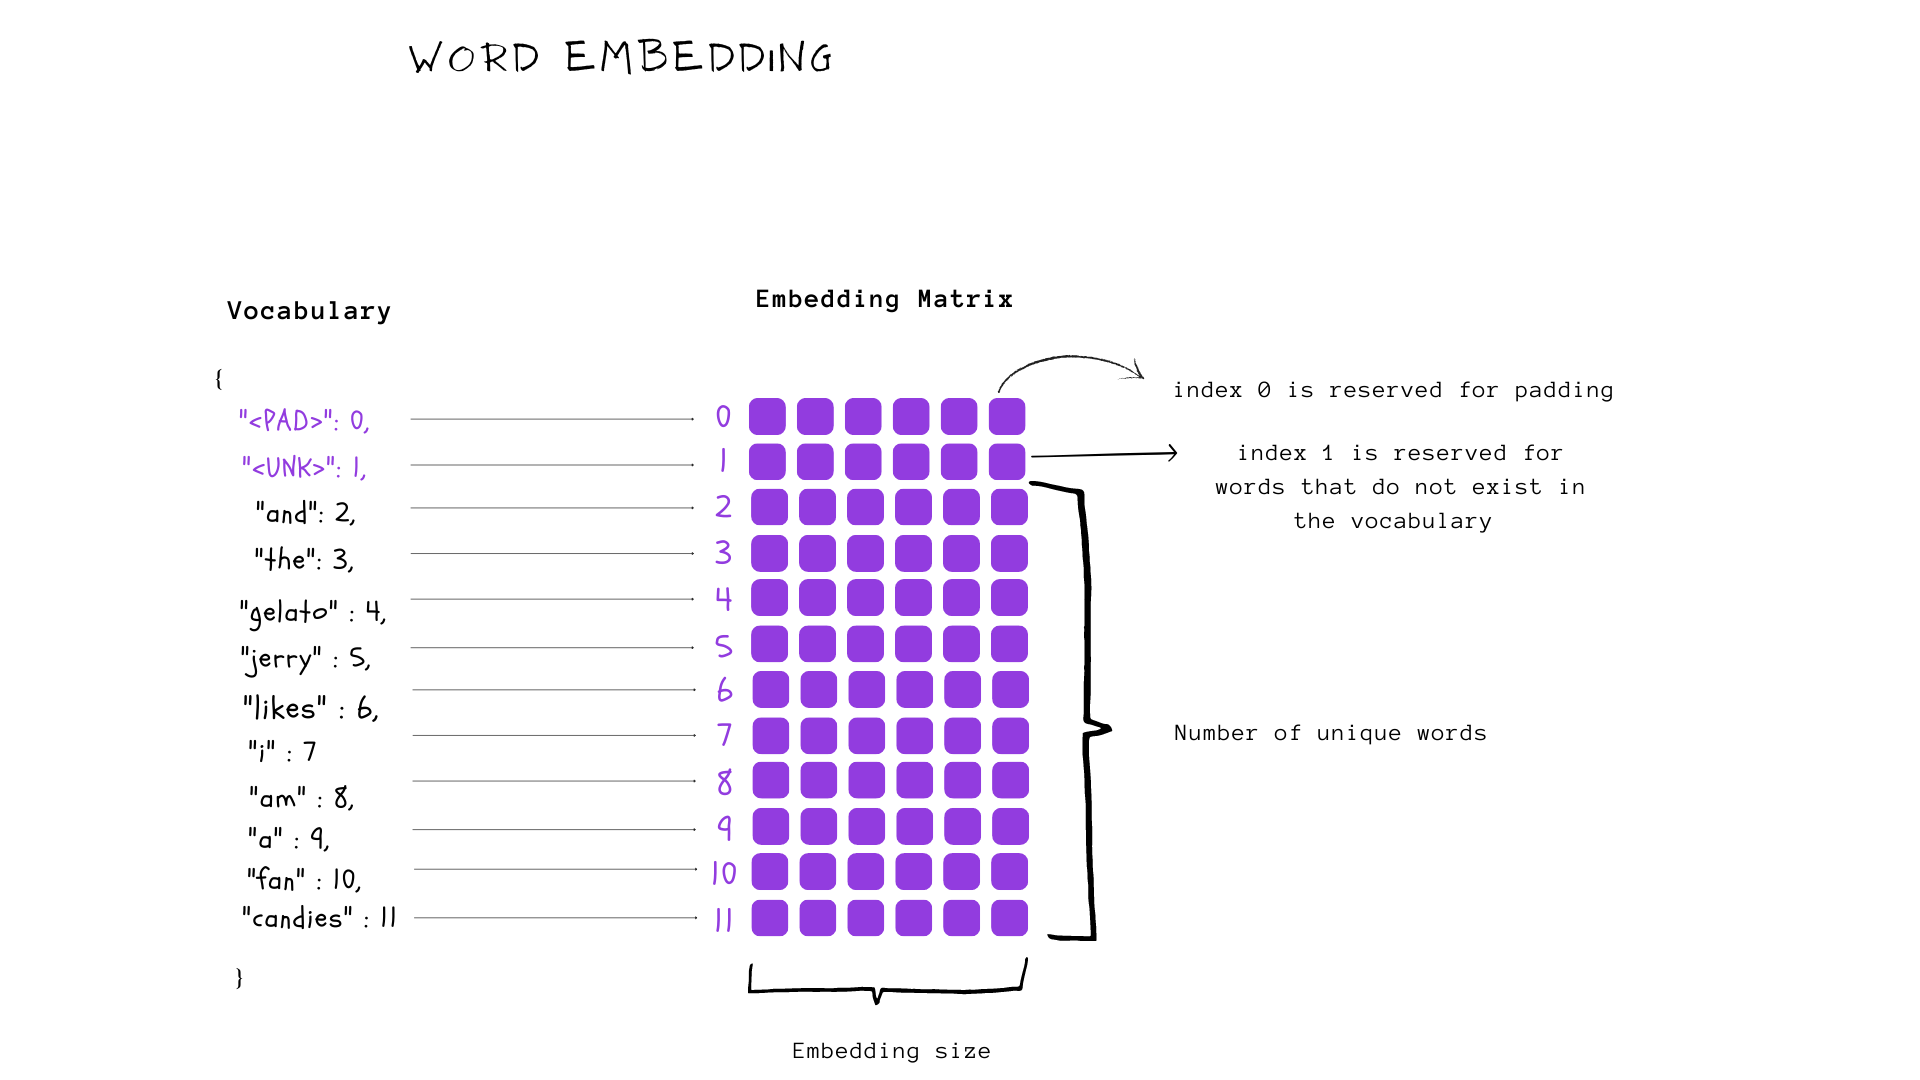

In [94]:
embedding_layer = nn.Embedding(num_embeddings=12, embedding_dim=6)

In [95]:
embedding_layer.weight

Parameter containing:
tensor([[-0.4960,  1.5998, -0.9319, -1.2187, -0.1380,  0.7543],
        [ 1.2626, -1.5396, -0.0565, -0.0779, -0.7316,  0.3321],
        [ 0.4466,  0.3697,  1.7048, -1.2773, -0.7283,  1.0732],
        [ 0.6036, -0.6034,  0.2829,  1.7324, -1.4179, -0.0981],
        [ 0.0257, -0.1644,  0.4955,  0.1374,  1.3454, -0.2259],
        [ 1.2504, -1.2559, -1.7721,  0.7195, -0.5400, -0.4953],
        [ 1.4480, -1.4102, -0.9058,  1.5948, -0.6183,  0.0212],
        [-0.6833, -0.8758,  1.2202,  0.4334,  0.9398, -0.4277],
        [-0.4033,  0.1614,  1.0604, -0.1795, -2.2718, -2.9570],
        [-0.4353, -0.1325, -0.6698, -0.3940, -1.2806,  0.4699],
        [-0.6889,  0.0688,  1.4310, -1.8103, -0.2546,  0.1568],
        [-0.2165,  1.3244,  0.5054,  0.1199,  0.5927, -0.2084]],
       requires_grad=True)

In [97]:
# retrieve first 3 embedding vectors
embedding_layer(torch.tensor([10, 11]))

tensor([[-0.6889,  0.0688,  1.4310, -1.8103, -0.2546,  0.1568],
        [-0.2165,  1.3244,  0.5054,  0.1199,  0.5927, -0.2084]],
       grad_fn=<EmbeddingBackward0>)

## <h6 style="text-align: center;"><b>Build RNN Language Model</b>

In [100]:
import torch.nn as nn
class RowlingRNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, drop_prob=0.2):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim )
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size)
        self.linear_layer = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, input_sequences):
        embeddings = self.dropout(self.embedding_layer(input_sequences))
        hidden_states, (last_hidden_state, last_cell_state) = self.rnn_layer(embeddings)
        predictions = self.linear_layer(hidden_states)
        return predictions

In [101]:
vocab_size = len(vocabulary)
embedding_dim = 256
hidden_size = 512

In [103]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# instantiate the model and transfer to device
language_model = RowlingRNN(vocab_size, embedding_dim, hidden_size)
language_model = language_model.to(device)

RowlingRNN(
  (embedding_layer): Embedding(5504, 256)
  (rnn_layer): LSTM(256, 512)
  (linear_layer): Linear(in_features=512, out_features=5504, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [105]:
optimizer = torch.optim.Adam(language_model.parameters())
loss_fn = nn.CrossEntropyLoss()

## <h6 style="text-align: center;"><b>Train RNN Language model</b>

In [30]:
num_iterations = 120000
language_model.train()

for iteration in range(num_iterations):
    
    # step 0. get training data
    input_batch, target_batch = next(iter(dataloader))
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    # step 1. compute prediction
    prediction = language_model(input_batch)
    
    # step 2. compute the loss
    # reshape prediction and target tensors
    prediction=prediction.view(-1, prediction.shape[-1]) # from 3D to 2D matrix
    target_batch=target_batch.view(-1) # from 2D to 1D vector
    
    loss = loss_fn(prediction, target_batch)
    
    # step 3. compute gradients
    loss.backward()
    
    # step 4. update params
    optimizer.step()
    
    # step 5. zero gradients
    optimizer.zero_grad()
    
    # step 6. reporting
    los_value = loss.item() 
    
    if iteration % 10000 == 0:
        print(f"Iteration {iteration} loss: {los_value:.4f}")

Iteration 0 loss: 8.6163
Iteration 10000 loss: 2.2142
Iteration 20000 loss: 1.6923
Iteration 30000 loss: 1.4209
Iteration 40000 loss: 1.2589
Iteration 50000 loss: 1.2593
Iteration 60000 loss: 1.1670
Iteration 70000 loss: 1.3279
Iteration 80000 loss: 1.0828
Iteration 90000 loss: 1.1099
Iteration 100000 loss: 1.0160
Iteration 110000 loss: 1.0689


In [47]:
# save the parameters of your model (without the architecture)
torch.save(language_model.state_dict(), "HP_model_params.pt")

In [137]:
# create the model architecture first, then load parameters
model.load_state_dict(torch.load("HP_model_params.pt"))

<All keys matched successfully>

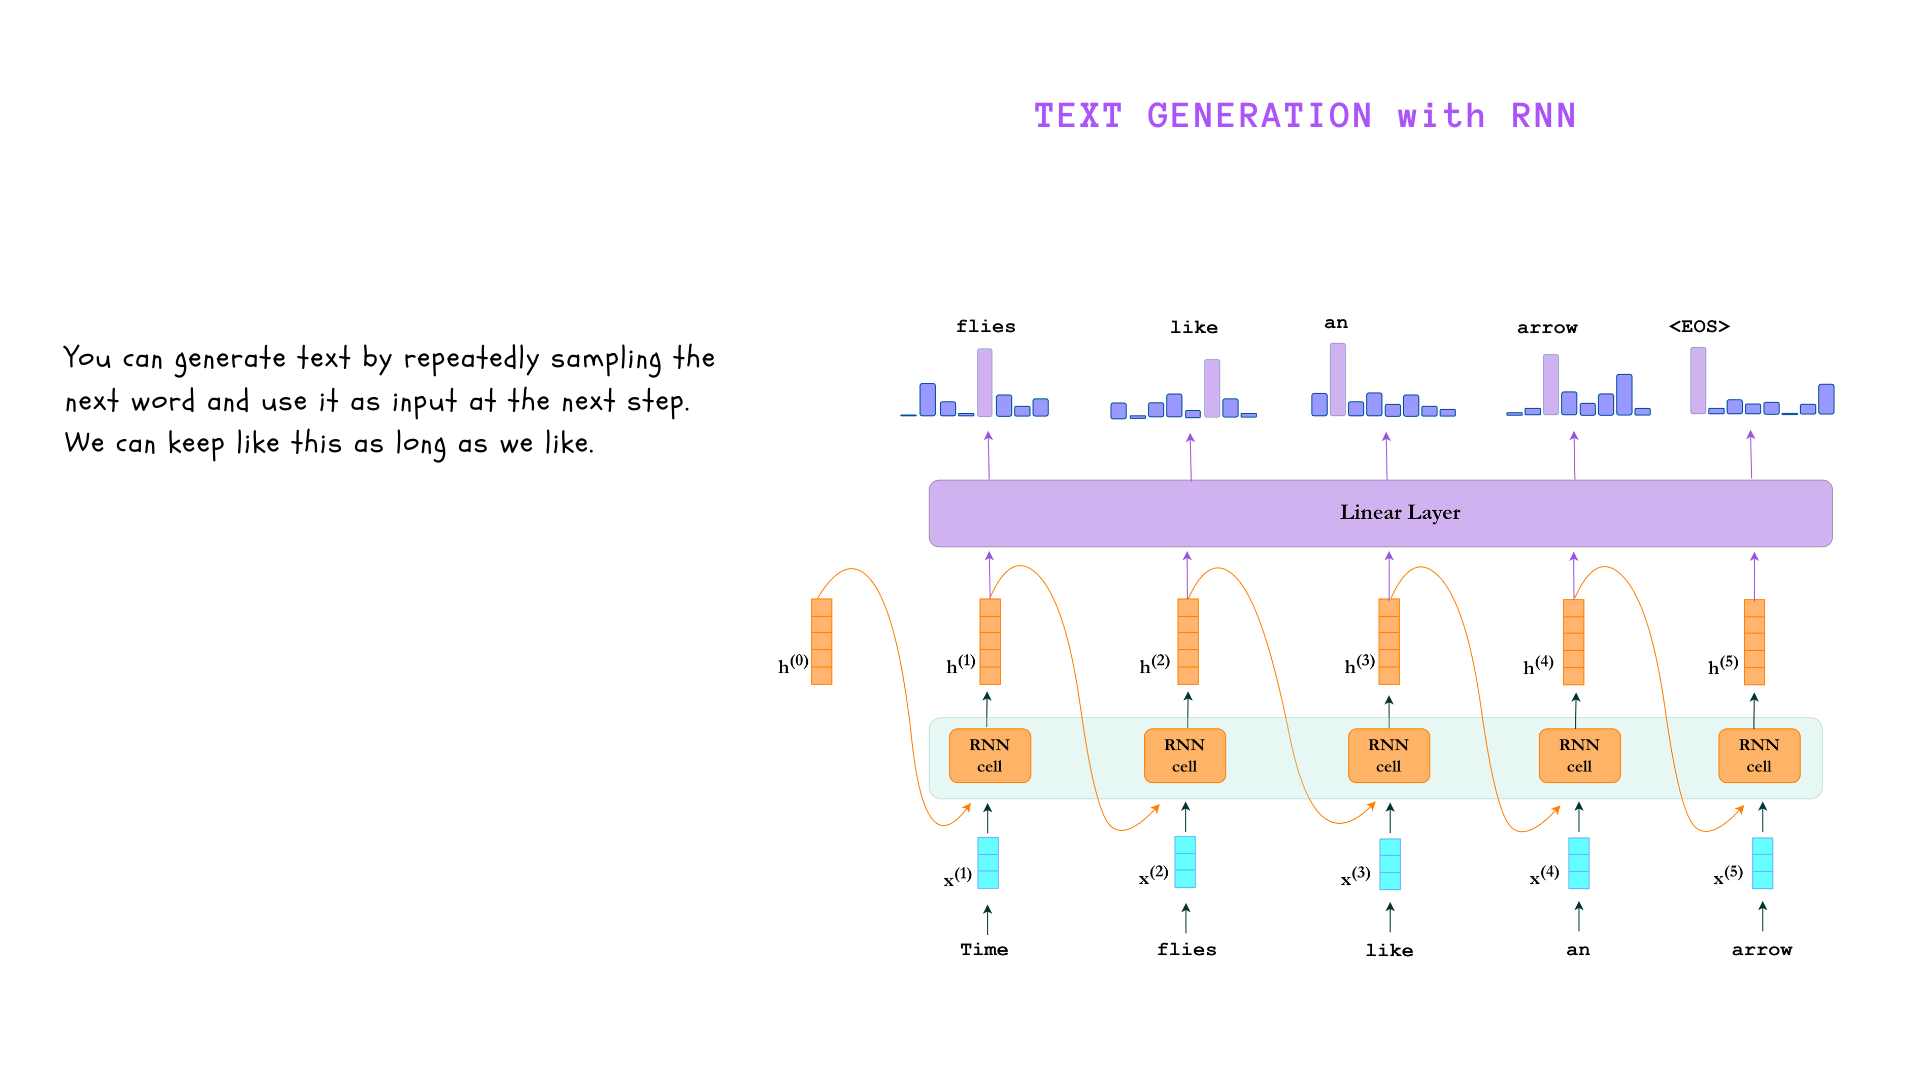

    The output of the model at each time step is the prediction vector,
    which we turn into probability distribution with softmax layer.
    We then use ``torch.multinomial()`` sampling function to sample from the predicted distribution.
    This function selects an index with probability proportional to the probability at that index.

In [35]:
import torch.nn.functional as F

def sample_and_decode(language_model, max_seq_len=15, prefix=None, tempreture = 1.):
    language_model.eval()
    with torch.no_grad():
        if prefix is None:
            prefix = "harry"
            
        indices = encode(prefix.split(), vocabulary)
        x_t = torch.LongTensor(indices).to(device)
        hidden = torch.zeros(1, 1, hidden_size).to(device)
        cell = torch.zeros(1, 1, hidden_size).to(device)
        
        for t in range(max_seq_len):
            
            # embed the prefix with embedding matrix
            emb_t = language_model.embedding_layer(x_t.view(1, -1))
            
            # compite hidden_state
            output, (hidden, cell) = language_model.rnn_layer(emb_t, (hidden, cell))
            
            # compute prediction vector
            predictions = language_model.linear_layer(hidden) * 1/tempreture
            
            # obtain a probability distribution
            probs = F.softmax(predictions, dim=-1).squeeze(0) 
            
            # sample from the probability distribution one index
            sampled_index = torch.multinomial(probs, num_samples=1)
            indices.append(sampled_index.item())
            
            # reset current word to the samples index
            x_t = sampled_index
            
    return " ".join(vocabulary.lookup_tokens(list(indices)))

In [48]:
sample_and_decode(language_model, max_seq_len = 100, prefix = "harry")

'harry could watch the red-haired family on the platform and hear what they were saying . their mother had just taken out her handkerchief . “ ron , you’ve got something on your nose . ” the youngest boy tried to jerk out of the way , but she grabbed him and began rubbing the end of his nose . “ that , he has come to protect harry potter , to warn him , even if they are they ? ” he hissed . “ oh , a fair few . . . . keep themselves to themselves mostly ,'

In [45]:
sample_and_decode(language_model, max_seq_len = 100, prefix = "harry", tempreture=2)

'harry stretched out his hand to make sure he liked . harry also happened . her mouth , deserted corridor know about not finding flamel in a slytherin , ” they each grabbed looks a chocolate frog , a his <unk> with , but it sped toward the ready boy . mrs . dursley was clutching what i and see why was pulling me what even destroyed ? ” “ hagrid ! ” hermione raised . “ what the we’ve got to do with the dursleys if it’s in front bathroom . . i’m lying one — obvious <unk> , there'

In [40]:
sample_and_decode(language_model, max_seq_len = 100, prefix = "harry", tempreture=0.2)

'harry . “ you could’ve fried an egg on your face , ” said ron . “ you’d better hope creevey doesn’t meet ginny , or they’ll be starting a harry potter fan club . ” when hermione had bustled off to check on the polyjuice potion again , ron turned to harry with a <unk> expression . “ have you ever heard of a plan where so many things could go wrong ? ” but to harry’s and ron’s utter amazement , stage one of the operation went just as smoothly as hermione had said . they <unk> in the'